In [1]:
import numpy as np
import pandas as pd

import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

In [2]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/tunguz/big-five-personality-test')
df = pd.read_csv('/content/big-five-personality-test/IPIP-FFM-data-8Nov2018/data-final.csv', sep = '\t')
df = df[df.columns[:50]].rename(columns={'EST1': 'NRT1', 'EST2': 'NRT2', 'EST3': 'NRT3', 'EST4': 'NRT4', 'EST5': 'NRT5', 'EST6': 'NRT6', 'EST7': 'NRT7', 'EST8': 'NRT8',
       'EST9': 'NRT9', 'EST10': 'NRT10'})

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: swake17
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tunguz/big-five-personality-test


100%|██████████| 159M/159M [00:05<00:00, 27.9MB/s]


#Data Cleaning



In [3]:
df.dropna(inplace=True)

Are questions properly reversed scored?

In [4]:
extroversion_columns = ['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9',
       'EXT10']

extroversion_questions = [
'I am the life of the party',
'I dont talk a lot',
'I feel comfortable around people',
'I keep in the background',
'I start conversations',
'I have little to say',
'I talk to a lot of different people at parties',
'I dont like to draw attention to myself',
'I dont mind being the center of attention',
'I am quiet around strangers']

for i in range(len(extroversion_columns)):
  print('{}: {}'.format(extroversion_columns[i], extroversion_questions[i]))

EXT1: I am the life of the party
EXT2: I dont talk a lot
EXT3: I feel comfortable around people
EXT4: I keep in the background
EXT5: I start conversations
EXT6: I have little to say
EXT7: I talk to a lot of different people at parties
EXT8: I dont like to draw attention to myself
EXT9: I dont mind being the center of attention
EXT10: I am quiet around strangers


Columns to reverse score:


* EXT2: I dont talk a lot
* EXT4: I keep in the background
* EXT6: I have little to say
* EXT8: I dont like to draw attention to myself
* EXT10: I am quiet around strangers





<Axes: >

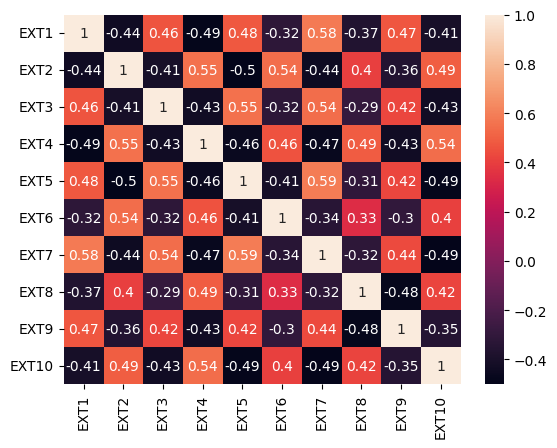

In [5]:
sns.heatmap(df.loc[:, extroversion_columns].corr(), annot=True)

Reverse score columns are all negatively correlated with non-reverse score columns: This indicates values have not been reverse scored, so this will need to be done manually. First, find which columns are reversed for all 5 personality traits:

**Neuroticism:**
* NRT1 : I get stressed out easily
* NRT2 : I am relaxed most of the time
* NRT3 : I worry about things
* NRT4 : I seldom feel blue
* NRT5 : I am easily disturbed
* NRT6 : I get upset easily
* NRT7 : I change my mood a lot
* NRT8 : I have frequent mood swings
* NRT9 : I get irritated easily
* NRT10: I often feel blue


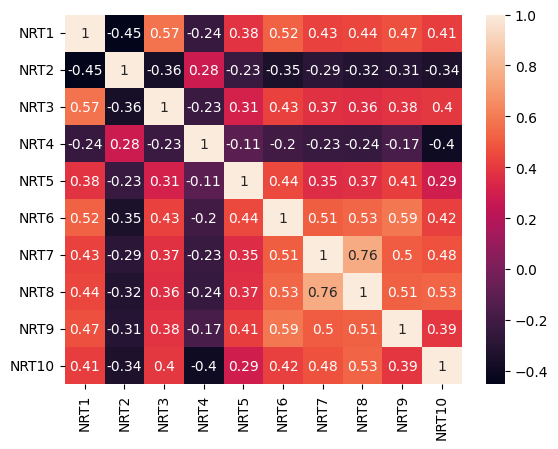

In [6]:
sns.heatmap(df.iloc[:, 10:20].corr(), annot=True);

**Agreeableness**
* AGR1 : I feel little concern for others
* AGR2 : I am interested in people
* AGR3 : I insult people
* AGR4 : I sympathize with others feelings
* AGR5 : I am not interested in other peoples problems
* AGR6 : I have a soft heart
* AGR7 : I am not really interested in others
* AGR8 : I take time out for others
* AGR9 : I feel others emotions
* AGR10: I make people feel at ease


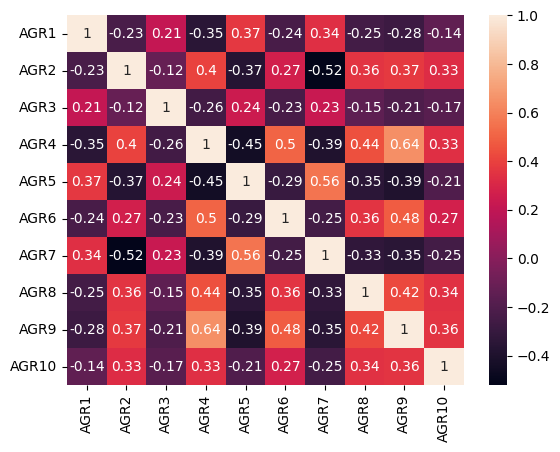

In [7]:
sns.heatmap(df.iloc[:, 20:30].corr(), annot=True);

**Conscientiousness**
* CSN1 : I am always prepared
* CSN2 : I leave my belongings around
* CSN3 : I pay attention to details
* CSN4 : I make a mess of things
* CSN5 : I get chores done right away
* CSN6 : I often forget to put things back in their proper place
* CSN7 : I like order
* CSN8 : I shirk my duties
* CSN9 : I follow a schedule
* CSN10 : I am exacting in my work

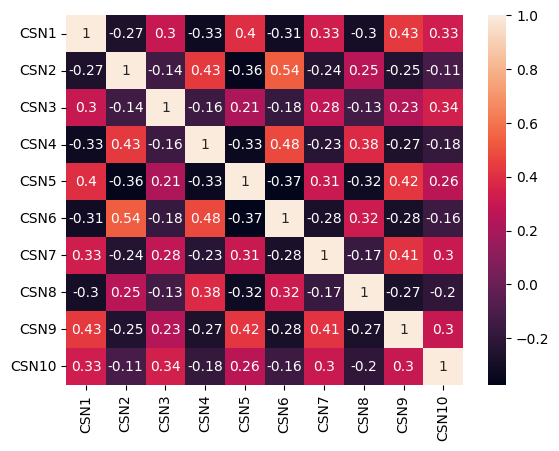

In [8]:
sns.heatmap(df.iloc[:, 30:40].corr(), annot=True);




**Openness**
* OPN1 : I have a rich vocabulary
* OPN2 : I have difficulty understanding abstract ideas
* OPN3 : I have a vivid imagination
* OPN4 : I am not interested in abstract ideas
* OPN5 : I have excellent ideas
* OPN6 : I do not have a good imagination
* OPN7 : I am quick to understand things
* OPN8 : I use difficult words
* OPN9 : I spend time reflecting on things
* OPN10: I am full of ideas

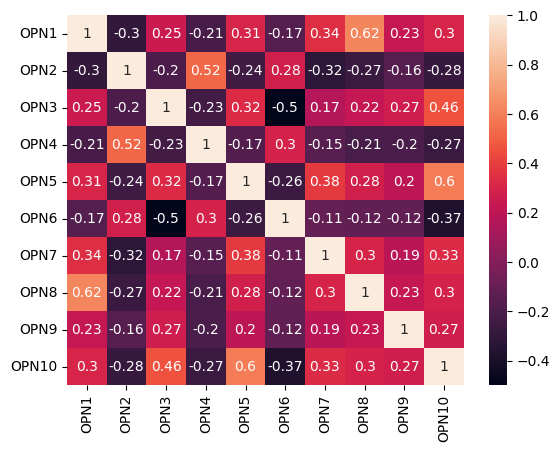

In [9]:
sns.heatmap(df.iloc[:, 40:50].corr(), annot=True);

In [10]:
print(df.head().value_counts())

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  NRT1  NRT2  NRT3  NRT4  NRT5  NRT6  NRT7  NRT8  NRT9  NRT10  AGR1  AGR2  AGR3  AGR4  AGR5  AGR6  AGR7  AGR8  AGR9  AGR10  CSN1  CSN2  CSN3  CSN4  CSN5  CSN6  CSN7  CSN8  CSN9  CSN10  OPN1  OPN2  OPN3  OPN4  OPN5  OPN6  OPN7  OPN8  OPN9  OPN10
2.0   2.0   2.0   3.0   4.0   2.0   2.0   4.0   1.0   4.0    3.0   3.0   3.0   2.0   3.0   2.0   2.0   2.0   4.0   3.0    2.0   4.0   3.0   4.0   2.0   4.0   2.0   4.0   3.0   4.0    2.0   4.0   4.0   4.0   1.0   2.0   2.0   3.0   1.0   4.0    4.0   2.0   5.0   2.0   3.0   1.0   4.0   4.0   3.0   3.0      1
      3.0   4.0   4.0   3.0   2.0   1.0   3.0   2.0   5.0    4.0   4.0   4.0   2.0   2.0   2.0   2.0   2.0   1.0   3.0    1.0   4.0   1.0   4.0   2.0   4.0   1.0   4.0   4.0   3.0    4.0   2.0   2.0   2.0   3.0   3.0   4.0   2.0   4.0   2.0    5.0   1.0   2.0   1.0   4.0   2.0   5.0   3.0   4.0   4.0      1
3.0   3.0   3.0   3.0   5.0   3.0   3.0   5.0   3.0   4.0    1.0   5.0   5.0  

In [11]:
#questions are scored on scale of 1-5

cols_to_reverse = ['EXT2', 'EXT4', 'EXT6', 'EXT8', 'EXT10',
                  'NRT2', 'NRT4',
                  'AGR1', 'AGR3', 'AGR5', 'AGR7',
                  'CSN2', 'CSN4', 'CSN6', 'CSN8',
                  'OPN2', 'OPN4', 'OPN6']

for col in cols_to_reverse:
  df[col] = 6-df[col]

#Exploratory Data Analysis

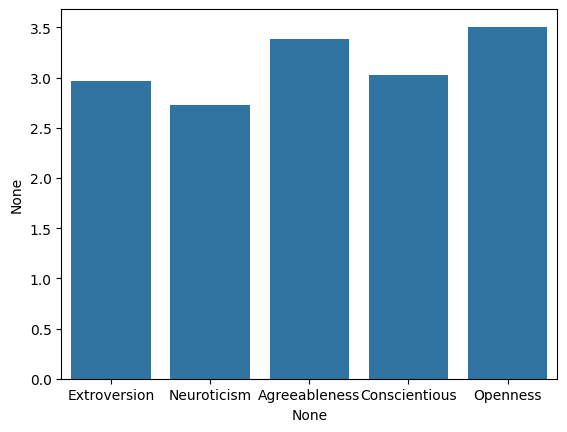

In [12]:
#Overall trait means

big5 = pd.DataFrame()
big5['Extroversion']=df.iloc[:, :10].sum(axis=1)/10
big5['Neuroticism']=df.iloc[:, 11:20].sum(axis=1)/10
big5['Agreeableness']=df.iloc[:, 21:30].sum(axis=1)/10
big5['Conscientious']=df.iloc[:, 31:40].sum(axis=1)/10
big5['Openness']=df.iloc[:, 41:50].sum(axis=1)/10


sns.barplot(x = big5.mean().index, y = big5.mean());

In [13]:
#Distribution of subscale question values for each trait:
np.where('EXT' in df.columns)

<ipython-input-13-7e960a44efe0>:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where('EXT' in df.columns)


(array([], dtype=int64),)

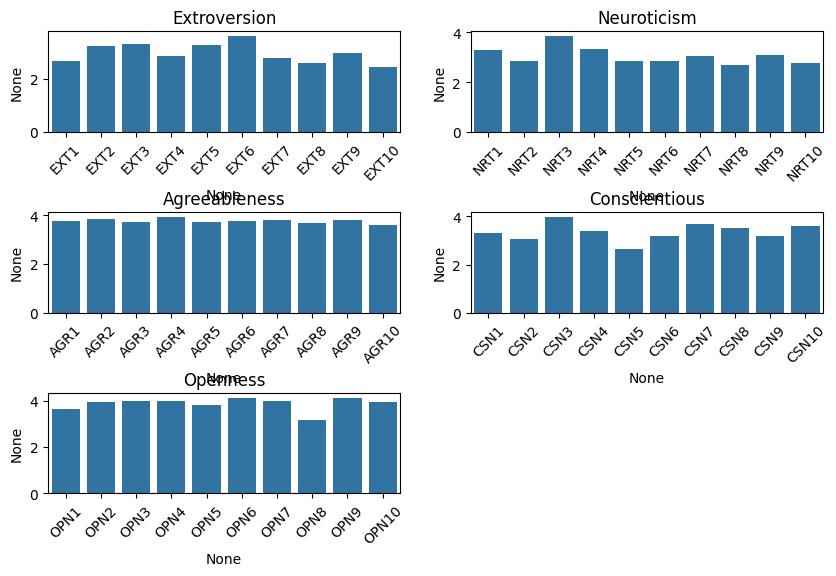

In [14]:
traits_abr = ['EXT', 'NRT', 'AGR', 'CSN', 'OPN']
traits = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientious',
       'Openness']

plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.8)
for i in range(len(traits_abr)):
  plt.subplot(3,2,i+1)
  cols = [col for col in df.columns if traits_abr[i] in col]
  data = df[cols]
  sns.barplot(x=data.mean().index, y=data.mean())
  plt.title(traits[i])
  plt.xticks(rotation=45)

plt.show()


###Differences in big 5 personality traits across global regions

In [15]:
country = pd.read_csv('/content/big-five-personality-test/IPIP-FFM-data-8Nov2018/data-final.csv', sep = '\t')['country']
countries_df = pd.concat([big5, country], axis=1)

#load dataset with regions mapped to country codes
continents = pd.read_csv('https://raw.githubusercontent.com/swake17/personality_druguse/main/continents2.csv')

#join on region and subregion
regions = continents[['alpha-2','region', 'sub-region']]
regions = regions.rename(columns={'alpha-2':'country', 'sub-region':'sub_region'})

countries_df = pd.merge(countries_df, regions, how='left', on='country')

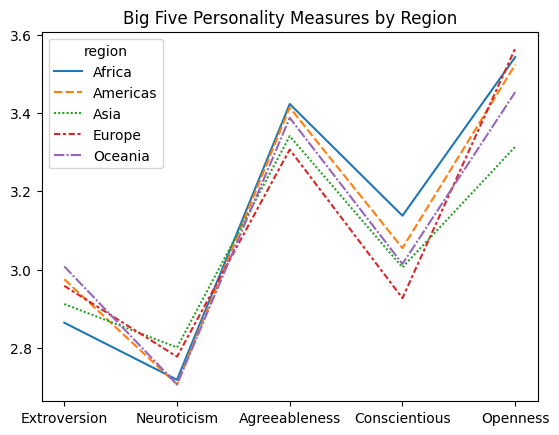

In [16]:
sns.lineplot(data=countries_df.groupby('region').mean(numeric_only=True).T)
plt.title('Big Five Personality Measures by Region')
plt.show()


#Cluster Analysis

In [17]:
#X is all 50 questions: 10 per overriding personality trait
#country/region not included
X = df

In [18]:
"""
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(X)
elbow.show()
"""

'\nfrom sklearn.cluster import KMeans\nfrom yellowbrick.cluster import KElbowVisualizer\n\nkmeans = KMeans()\nelbow = KElbowVisualizer(KMeans(), k=10)\nelbow.fit(X)\nelbow.show()\n'

#KMeans with n=5

In [19]:
kmeans = KMeans(n_clusters=5).fit(X)
kmeans_clusters = kmeans.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###**Visualizing with PCA**

In [20]:
#Visualize with PCA
PCA_components = PCA(n_components=2).fit_transform(X)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


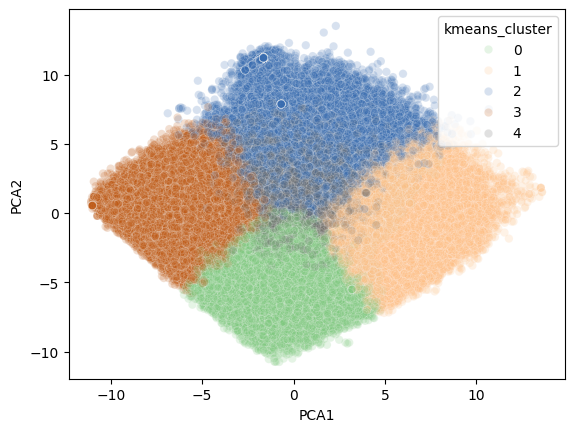

In [21]:
#2 dimensions:
PCA_df= pd.DataFrame(data=PCA_components, columns = ['PCA1', 'PCA2'])
PCA_df['kmeans_cluster'] = kmeans_clusters

sns.scatterplot(data=PCA_df, x='PCA1', y='PCA2', hue='kmeans_cluster', palette = plt.colormaps['Accent'], alpha=0.2)
plt.show()

In [22]:
PCA_3D = PCA(n_components=3).fit_transform(X)


<Figure size 1500x1500 with 0 Axes>

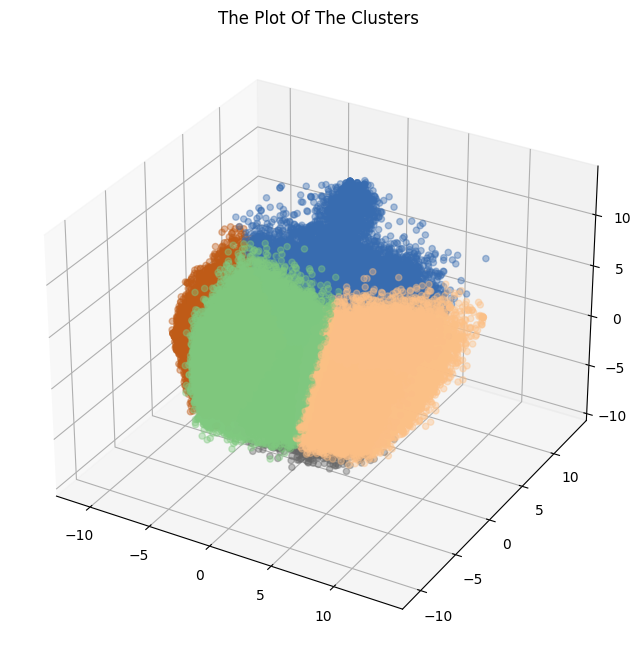

In [23]:

plt.figure(figsize=(15,15))
df_3D = pd.DataFrame(PCA_3D, columns = ['PCA1', 'PCA2', 'PCA3'])

df_3D['cluster'] = kmeans_clusters
x = df_3D['PCA1']
y = df_3D['PCA2']
z = df_3D['PCA3']

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=20, c=df_3D["cluster"], marker='o', cmap = plt.colormaps['Accent'], alpha=0.4)
ax.set_title("The Plot Of The Clusters")
plt.show()

###**Visualizing with t-SNE**

In [30]:

subset_indeces = np.arange(0, 800000, 160)


#create manageable subset of n=5000
X_subset = X.iloc[subset_indeces]


tsne = TSNE(n_components=2).fit_transform(X_subset)

tsne_df = pd.DataFrame(tsne, columns = ['tSNE1', 'tSNE2'])
tsne_df['kmeans_cluster'] = kmeans_clusters[subset_indeces]

In [ ]:
import matplotlib.pyplot as plt


sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='kmeans_cluster', palette = plt.colormaps['Accent'], alpha=0.7)
plt.show()

#Examining properties of each cluster

In [ ]:
big5_clusters = pd.DataFrame()
big5_clusters['Extroversion']=df.iloc[:, :10].sum(axis=1)/10
big5_clusters['Neuroticism']=df.iloc[:, 11:20].sum(axis=1)/10
big5_clusters['Agreeableness']=df.iloc[:, 21:30].sum(axis=1)/10
big5_clusters['Conscientious']=df.iloc[:, 31:40].sum(axis=1)/10
big5_clusters['Openness']=df.iloc[:, 41:50].sum(axis=1)/10

big5_clusters['cluster'] = kmeans_clusters

sns.barplot(x = big5_clusters['cluster'].value_counts().index, y = big5_clusters['cluster'].value_counts(), palette = 'cubehelix')
plt.xlabel('Cluster')
plt.ylabel('# of Members')
plt.title('Distribution of Data Points Across Clusters')
plt.show()

In [ ]:
plt.figure(figsize = (20,4))
for i in range(5):
  plt.subplot(1,5, i+1)
  data = big5_clusters[big5_clusters['cluster']==i].drop('cluster', axis=1)
  sns.barplot(x = data.mean().index, y = data.mean(), color = 'skyblue', alpha=0.5)
  sns.lineplot(x = data.mean().index, y = data.mean(), color = 'black')
  plt.xticks([0,1,2,3,4], ['EXT', 'NRT', 'AGR', 'CSN', 'OPN'], rotation=30)
  plt.yticks([0, 1, 2, 3, 4])
  plt.title('Cluster' + str(i))
plt.show()


###How similar are the cluster assignments when performing KMeans on only total scores for each 5 big traits?

In [ ]:
X_trait = big5

kmeans = KMeans(n_clusters=5).fit(X_trait)
kmeans_clusters = kmeans.predict(X_trait)


In [ ]:
#Visualize with PCA
PCA_components_trait = PCA(n_components=2).fit_transform(X_trait)
#2 dimensions:
PCA_df_trait= pd.DataFrame(data=PCA_components_trait, columns = ['PCA1', 'PCA2'])
PCA_df_trait['kmeans_cluster'] = kmeans_clusters

sns.scatterplot(data=PCA_df_trait, x='PCA1', y='PCA2', hue='kmeans_cluster', palette = plt.colormaps['Accent'], alpha=0.7)
plt.show()

In [ ]:
df_compare = pd.DataFrame()

#column for cluster membership baed on subscale measures
df_compare['subscales'] = PCA_df['kmeans_cluster']

#column for cluster membership based only on aggregated trait measures
df_compare['trait_totals'] = PCA_df_trait['kmeans_cluster']



In [ ]:
#cluster values are assigned randomly
#reassign trait_totals_predict clusters to match those of full prediction
#assume clusters with maximum number of overlapping assignments are the same

crosstab = pd.crosstab(df_compare['subscales'], df_compare['trait_totals'])
max_indeces = crosstab.idxmax(axis=0)
replace_dict = max_indeces.to_dict()
df_compare = df_compare.replace({'trait_totals' : replace_dict})

In [ ]:
pd.crosstab(df_compare['subscales'], df_compare['trait_totals'])

In [ ]:
print('RI: {}\nARI: {}'.format(metrics.rand_score(df_compare['subscales'], df_compare['trait_totals']), metrics.adjusted_rand_score(df_compare['subscales'], df_compare['trait_totals'])))

#Gaussian Mixture Model with n_clusters=5

In [ ]:
X = df
gmm = GaussianMixture(n_components=5).fit(X)
gmm_clusters = gmm.predict(X)


In [ ]:

#Visualize with PCA
PCA_components = PCA(n_components=2).fit_transform(X)
PCA_df= pd.DataFrame(data=PCA_components, columns = ['PCA1', 'PCA2'])
PCA_df['gmm_cluster'] = gmm_clusters

sns.scatterplot(data=PCA_df, x='PCA1', y='PCA2', hue='gmm_cluster', palette = plt.colormaps['Accent'], alpha=0.7)
plt.show()


#Comparison of similarity scores: KMeans and GMM

In [ ]:
sample_indeces = np.arange(0, 800000, 160)
X_sample = X.iloc[sample_indeces]
kmeans_clusters_sample = kmeans_clusters.iloc[sample_indeces]
gmm_clusters_sample = gmm_clusters.iloc[sample_indeces]


print('KMeans silhouette score: {}'.format(metrics.silhouette_score(X_sample, kmeans_clusters_sample, metric='euclidean')))
print('Gaussian Mixture silhoutte score: {}'.format(metrics.silhouette_score(X_sample, gmm_clusters_sample, metric='euclidean')))